In [1]:
import tensorflow as tf
from tensorflow import keras

from nn.alice import dataset, model
from physics.hstar import gghzz, c6
from physics.simulation import msq
from physics.hzz import zpair, angles

import os
import json
import numpy as np
import matplotlib.pyplot as plt

import hist

from sklearn.preprocessing import MinMaxScaler

2024-12-17 14:46:16.648964: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-17 14:46:16.649004: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-17 14:46:16.649030: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-17 14:46:16.656269: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
SEED=373485

BASE_SIZE=10000

OUTPUT_DIR='jobs/alice/run-one'
CONF_FILE='alice-config.json'
SCALER_CONF='scaler.json'
SAMPLE_DIR='..'

In [3]:
with open(os.path.join(OUTPUT_DIR, CONF_FILE), 'r') as conf_file:
    config = json.load(conf_file)

In [4]:
sample_train = gghzz.Process(msq.Component.SIG, (0.1, os.path.join(SAMPLE_DIR, 'ggZZ2e2m_sig.csv'), 1.2*BASE_SIZE))
sample_val = gghzz.Process(msq.Component.SIG, (0.1, os.path.join(SAMPLE_DIR, 'ggZZ2e2m_sig.csv'), config['num_events'] + 1.2*BASE_SIZE))
sample_val.events = sample_val.events[config['num_events']:]

In [5]:
z_chooser = zpair.ZPairChooser(bounds1=(70,115), bounds2=(70,115), algorithm='leastsquare')
kin_vars_train = angles.calculate_2(*sample_train.events.filter(z_chooser))
kin_vars_val = angles.calculate_2(*sample_val.events.filter(z_chooser))

sample_train.events = sample_train.events[:BASE_SIZE]
kin_vars_train = kin_vars_train[:BASE_SIZE]
sample_val.events = sample_val.events[:BASE_SIZE]
kin_vars_val = kin_vars_val[:BASE_SIZE]

In [6]:
c6_values = [-20,-10,0,10,20]

c6_mod_train = c6.Modifier(baseline = msq.Component.SBI, sample=sample_train, c6_values = [-5,-1,0,1,5])
c6_weights_train, c6_prob_train = c6_mod_train.modify(c6=c6_values)

c6_mod_val = c6.Modifier(baseline = msq.Component.SBI, sample=sample_train, c6_values = [-5,-1,0,1,5])
c6_weights_val, c6_prob_val = c6_mod_val.modify(c6=c6_values)

In [7]:
train_set = dataset.build_dataset(x_arr=kin_vars_train, 
                                  param_values=c6_values, 
                                  signal_probabilities=c6_weights_train, 
                                  background_probabilities=sample_train.events.weights)
val_set = dataset.build_dataset(x_arr=kin_vars_val, 
                                param_values=c6_values, 
                                signal_probabilities=c6_weights_val, 
                                background_probabilities=sample_val.events.weights)

2024-12-17 14:46:29.707727: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [8]:
with open(os.path.join(OUTPUT_DIR, SCALER_CONF), 'r') as conf_file:
    scaler_conf = json.load(conf_file)

In [9]:
scaler = MinMaxScaler()
scaler.min_ = scaler_conf['scaler.min_']
scaler.scale_ = scaler_conf['scaler.scale_']

train_set = tf.concat([scaler.transform(train_set[:,:10]), train_set[:,10:]], axis=1)
val_set = tf.concat([scaler.transform(val_set[:,:10]), val_set[:,10:]], axis=1)

In [10]:
print(train_set[0])

tf.Tensor(
[7.8102767e-01 9.3859696e-01 2.9384297e-01 9.3281323e-01 6.3147950e-01
 6.7205107e-01 4.2874646e-01 1.7109354e-01 4.9951667e-01 0.0000000e+00
 9.2053866e-01 1.5892517e-06], shape=(12,), dtype=float32)


In [11]:
rolr_model = model.load(os.path.join(OUTPUT_DIR, 'checkpoint.model.tf'))

In [12]:
predictions_train = rolr_model.predict(train_set[:,:10])
predictions_val = rolr_model.predict(val_set[:,:10])

1563/1563 [==============================] - 38s 24ms/step


In [13]:
pred_train_per_c6 = {c6_values[i]: predictions_train[i*BASE_SIZE:(i+1)*BASE_SIZE] for i in range(len(c6_values))}
data_train_per_c6 = {c6_values[i]: train_set[i*BASE_SIZE:(i+1)*BASE_SIZE] for i in range(len(c6_values))}

pred_val_per_c6 = {c6_values[i]: predictions_val[i*BASE_SIZE:(i+1)*BASE_SIZE] for i in range(len(c6_values))}
data_val_per_c6 = {c6_values[i]: val_set[i*BASE_SIZE:(i+1)*BASE_SIZE] for i in range(len(c6_values))}

In [14]:
def generate_histograms(c6_values, data_train_per_c6, pred_train_per_c6, data_val_per_c6, pred_val_per_c6, num_bins):
    histograms = []
    for c6 in c6_values:
        hist_train = hist.Hist(hist.axis.Regular(num_bins, 0, 1, name='x', label='NN output []'))
        hist_train.fill(tf.squeeze(pred_train_per_c6[c6], axis=1))

        hist_val = hist.Hist(hist.axis.Regular(num_bins, 0, 1, name='x', label='NN output []'))
        hist_val.fill(tf.squeeze(pred_val_per_c6[c6], axis=1))

        hist_true = hist.Hist(hist.axis.Regular(num_bins, 0, 1, name='x', label='NN output []'))
        hist_true.fill(data_train_per_c6[c6][:,-2])

        histograms.append((hist_train.to_numpy(), hist_val.to_numpy(), hist_true.to_numpy()))
    
    return histograms

In [15]:
def plot_histograms(c6_values, histograms, colors, xlim=(0.2,0.8)):
    fig = plt.figure(figsize=(7,6))

    for i in range(len(c6_values)):
        plt.step(histograms[i][2][1][1:], histograms[i][2][0], color=colors[i], linestyle='--', label=f'truth (c6={c6_values[i]})', alpha=0.6)
        plt.step(histograms[i][0][1][1:], histograms[i][0][0], color=colors[i], label=f'training data (c6={c6_values[i]})', alpha=0.6)
        plt.scatter(histograms[i][1][1][1:], histograms[i][1][0], s=20, color=colors[i], label=f'validation data (c6={c6_values[i]})', alpha=0.6)

    plt.xlabel('NN output []')
    plt.ylabel('Percentage of predictions []')
    plt.legend()
    plt.xlim(xlim[0],xlim[1])
    plt.yscale('log')

    plt.show()

(10000,)
(10000, 1)


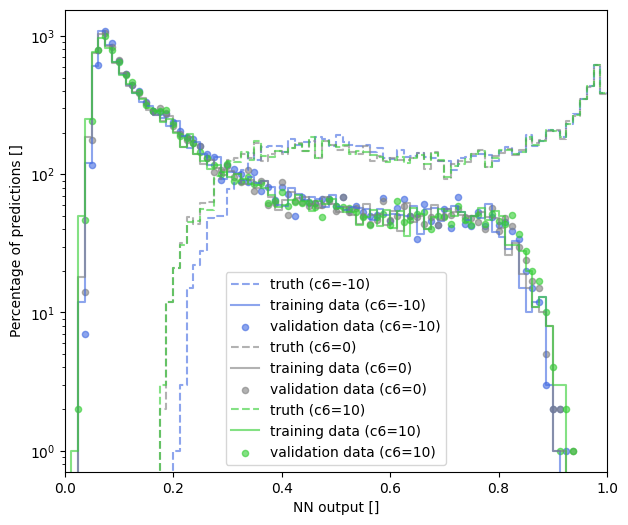

In [16]:
BINS = 80

c6_vals = [-10,0,10]
colors = ['royalblue','gray','limegreen']

print(data_train_per_c6[-10][:,-2].shape)
print(pred_train_per_c6[-10].shape)

histograms = generate_histograms(c6_vals, data_train_per_c6, pred_train_per_c6, data_val_per_c6, pred_val_per_c6, BINS)

plot_histograms(c6_vals, histograms, colors, xlim=(0,1))